In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset"

# Define transforms
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor()
    ]),

    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=image_transforms["train"])
val_data = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=image_transforms["val"])
test_data = datasets.ImageFolder(os.path.join(data_dir, "Test"), transform=image_transforms["val"])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# Class names
class_names = train_data.classes
print("Classes:", class_names)


Classes: ['WithMask', 'WithoutMask']


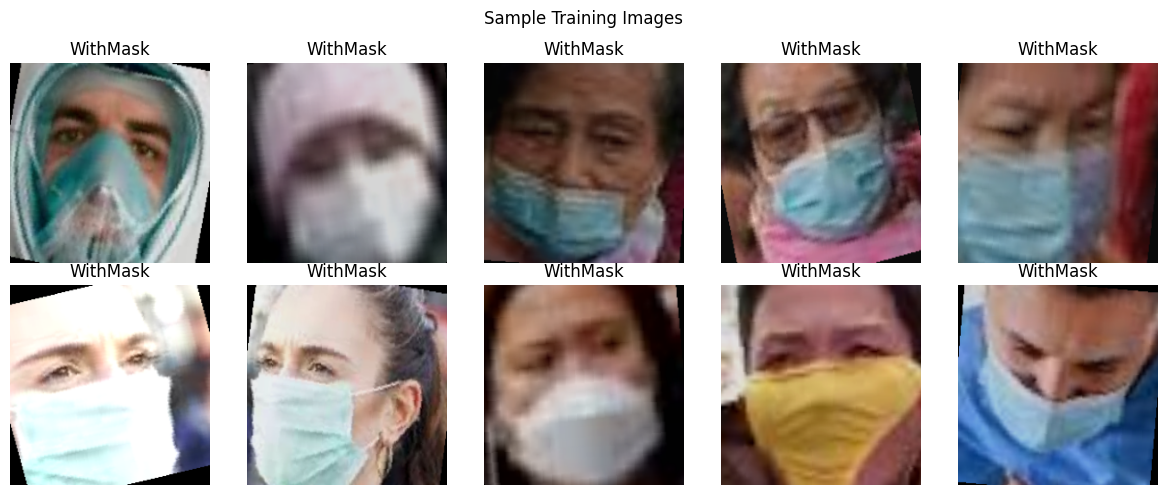

In [3]:
def show_samples(dataset, title):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flatten()):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_data, "Sample Training Images")


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=True)

# for param in mobilenet.features.parameters():
#     param.requires_grad = True

for name, param in mobilenet.named_parameters():
    if 'features.17' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Replace classifier head
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, len(class_names))

mobilenet = mobilenet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 153MB/s]


In [5]:

import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(logp, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


criterion = FocalLoss(alpha=1, gamma=2).to(device)
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)


In [6]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001, path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10,early_stopping=None):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss_ = criterion(val_outputs, val_labels)
                val_running_loss += val_loss_.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / val_total)
        if early_stopping:
            early_stopping(val_acc[-1], model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, train_acc, val_loss, val_acc


In [8]:
EPOCHS = 30

early_stopper = EarlyStopping(patience=5, delta=0.001, path='best_mobilenet.pt')

train_loss, train_acc, val_loss, val_acc = train_model(
    mobilenet, train_loader, val_loader, criterion, optimizer, device, EPOCHS, early_stopping=early_stopper
)

# Load best model after training
mobilenet.load_state_dict(torch.load('best_mobilenet.pt'))


Epoch [1/30] Train Loss: 0.0348, Train Acc: 0.9499 | Val Loss: 0.0395, Val Acc: 0.9387
Epoch [2/30] Train Loss: 0.0192, Train Acc: 0.9755 | Val Loss: 0.0236, Val Acc: 0.9700
Epoch [3/30] Train Loss: 0.0228, Train Acc: 0.9737 | Val Loss: 0.0281, Val Acc: 0.9563
Epoch [4/30] Train Loss: 0.0173, Train Acc: 0.9799 | Val Loss: 0.0544, Val Acc: 0.9350
Epoch [5/30] Train Loss: 0.0188, Train Acc: 0.9790 | Val Loss: 0.1750, Val Acc: 0.8313
Epoch [6/30] Train Loss: 0.0173, Train Acc: 0.9787 | Val Loss: 0.0284, Val Acc: 0.9625
Early stopping triggered.


<All keys matched successfully>

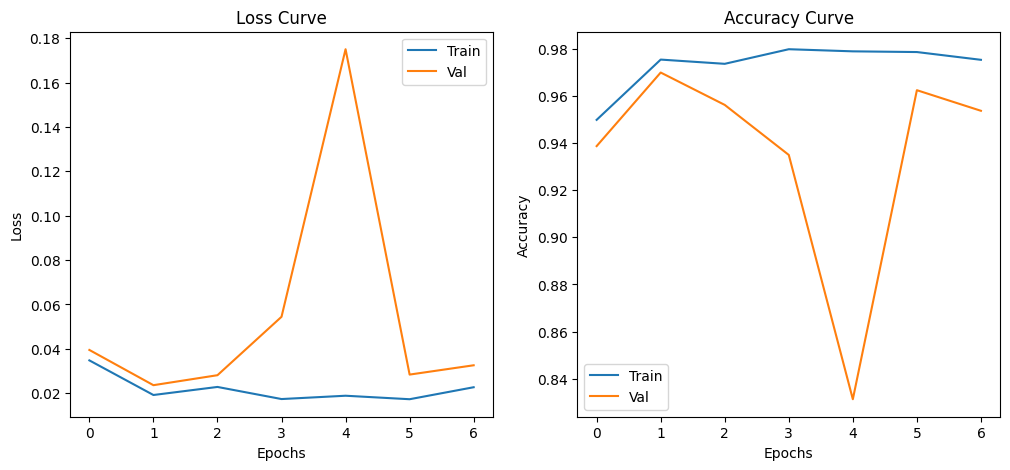

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



Classification Report:
              precision    recall  f1-score   support

    WithMask       0.97      0.96      0.96       483
 WithoutMask       0.96      0.97      0.96       509

    accuracy                           0.96       992
   macro avg       0.96      0.96      0.96       992
weighted avg       0.96      0.96      0.96       992



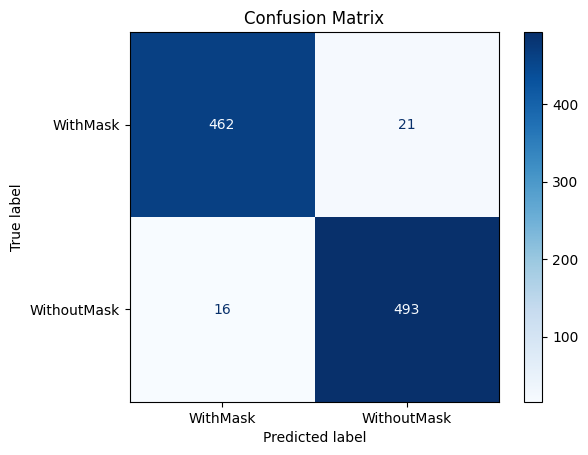

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(mobilenet, test_loader)


In [11]:
torch.save(mobilenet.state_dict(), "mask_detector.pt")
print("✅ Model saved as mask_detector.pt")


✅ Model saved as mask_detector.pt


#Testing on another dataset

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

   with_mask       0.85      0.91      0.88      3725
without_mask       0.91      0.85      0.88      3828

    accuracy                           0.88      7553
   macro avg       0.88      0.88      0.88      7553
weighted avg       0.88      0.88      0.88      7553



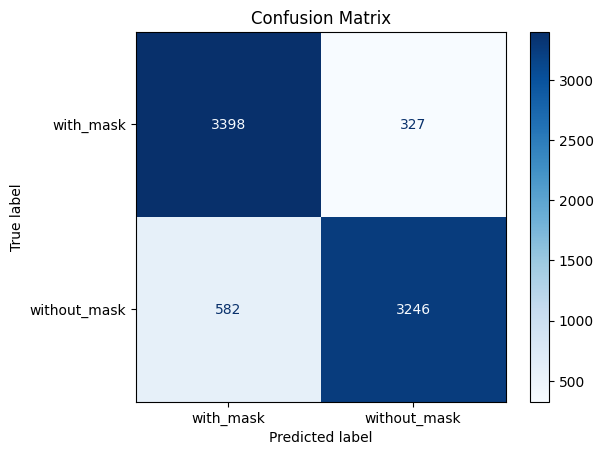

In [12]:
from torchvision import models
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 2)  # 2 classes

# Load weights correctly
mobilenet.load_state_dict(torch.load("mask_detector.pt", map_location=device))
mobilenet.to(device)
mobilenet.eval()


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder("/kaggle/input/face-mask-dataset/data", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names (should be: ['with_mask', 'without_mask'])
class_names = test_dataset.classes

evaluate_model(mobilenet, test_loader)


In [13]:
# # Detect face boxes with MTCNN
# boxes, _ = mtcnn.detect(frame)

# if boxes is not None:
#     for box in boxes:
#         x1, y1, x2, y2 = map(int, box)
#         face = frame[y1:y2, x1:x2]
        
#         # Only process if valid
#         if face.size == 0:
#             continue

#         # Preprocess
#         face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
#         input_tensor = transform(face_pil).unsqueeze(0).to(device)

#         with torch.no_grad():
#             outputs = model(input_tensor)
#             _, preds = torch.max(outputs, 1)
#             confidence = torch.softmax(outputs, dim=1)[0][preds.item()].item()
#             label = f"{class_names[preds.item()]} ({confidence*100:.1f}%)"

#         # Draw results
#         color = (0, 255, 0) if preds.item() == 0 else (0, 0, 255)
#         cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
#         cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
